# Sajad Hosseini Najafabadi
# 400301997
# DL2022_HW4_P3:

In [ ]:
# Install needed packages
!pip install transformers
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 16.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from transformers import BertModel
import seaborn as sns
import time
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Download data:

In [ ]:
# download poems
!git clone https://github.com/amnghd/Persian_poems_corpus
# get needed items and move to data folder 
! mv /content/Persian_poems_corpus/normalized /content/data/
# remove extra data
! rm -r /content/Persian_poems_corpus

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (3/3), done.


## Create dataset needed for BERT:

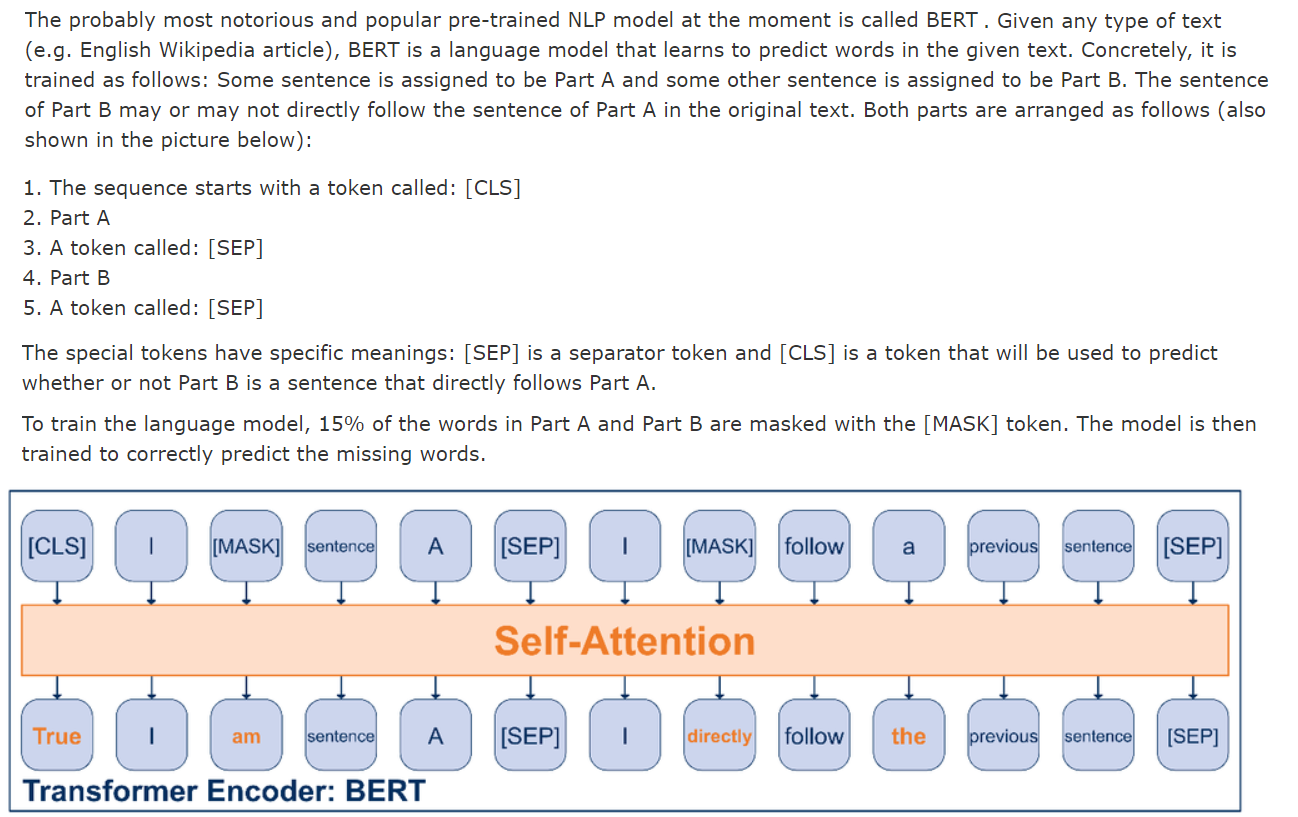

In [ ]:
# select desired poets
poets = {0: 'saadi', 1:'ferdousi', 2:'hafez', 3:'moulavi', 4:'attar', 5:'bahar',
         6:'khayyam', 7:'sanaee', 8:'roodaki', 9:'obeyd'}

max_len = 0
df = pd.DataFrame([])
for i in range(len(poets)):
  path = './data/' + poets[i] + '_norm.txt'
  verse = []
  with open(path) as f:
    for line in f:
      verse.append(line.strip())
      l = line.split(" ")
      if len(l) > max_len:
        max_len = len(l)
  # delete all rows that are empty
  verse = [line for line in verse if line != '']
  beyt = []
  for k in range(int(len(verse)/2)):
    # use the special token [SEP] as described before to create beyts from verses
    beyt.append(verse[2*k] + ' [SEP] ' +verse[2*k+1])
  poet = pd.DataFrame(beyt, columns = ['beyt'])
  poet['label'] = i
  df = pd.concat([df, poet], ignore_index=True,)
df

,beyt,label
0,اول دفتر به نام ایزد دانا [SEP] صانع پروردگار ...,0
1,اکبر و اعظم خدای عالم و آدم [SEP] صورت خوب آفر...,0
2,از در بخشندگی و بنده نوازی [SEP] مرغ هوا را نص...,0
3,قسمت خود می خورند منعم و درویش [SEP] روزی خود ...,0
4,حاجت موری به علم غیب بداند [SEP] در بن چاهی به...,0
...,...,...
242952,ببخشد حق بر این دلسوزی من [SEP] بود کان ماه گر...,9
242953,سخن سازان که دل پرنور دارند [SEP] غم دیوانه را...,9
242954,حدیثم چون ندارد رنگ و بویی [SEP] که خواهد کرد ...,9
242955,ز ما دانا دلان معنی نجویند [SEP] دماغ آشفتگان ...,9


In [ ]:
train, test = train_test_split(df, test_size=0.15)
tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

class custom_dataset(torch.utils.data.Dataset):

  def __init__(self, data):
    self.labels = np.array(data['label'])
    self.beyts = [tokenizer(line, padding='max_length', max_length = max_len, 
                 return_tensors="pt", truncation=True) for line in data['beyt']]

  def __len__(self):

    return len(self.labels)

  def __getitem__(self, idx):
    beyt = self.beyts[idx]
    label = self.labels[idx]

    return beyt, label

In [ ]:
ds_train = custom_dataset(train)
ds_test = custom_dataset(test)
# Let's see one sample of ds_train
ds_train[0]

({'input_ids': tensor([[    2,  9126,  2789,  3040,  9669,  2800,  9669,  2015,  9669, 14806,
           2785,  5579,     4,  2961,  9669, 16176,  3040,  9126,  8314, 28075,
           2008,  2822,     4,     0,     0,     0,     0,     0,     0,     0,
              0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
          0, 0, 0, 0, 0, 0, 0]])}, 4)

In [ ]:
# create dataloader
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(ds_test, batch_size=batch_size)

# 3.A. Transfer learning using a pre-trained BERT:

In [ ]:
pretrained_bert_model = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
# Freeze all parameters
for p in pretrained_bert_model.parameters():
  p.requires_grad = False
print(pretrained_bert_model)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [ ]:
class BERT(nn.Module):

  def __init__(self):
    super().__init__()
    self.bert = pretrained_bert_model
    self.dense = nn.Linear(768, 10)

  def forward(self, input_id, mask):
    _, x = self.bert(input_ids= input_id, attention_mask=mask, return_dict=False)
    x = self.dense(x)

    return x

In [ ]:
model_bert = BERT()
model_bert.to(device)
optimizer = torch.optim.Adam(model_bert.parameters(), lr = 5e-5)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    running_loss = 0
    for batch, (X, y) in enumerate(dataloader):

        input_id = X['input_ids'].squeeze(1).to(device)
        attention_mask = X['attention_mask'].to(device)
        y = y.to(device)

        pred = model(input_id, attention_mask)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch % 300 == 0:
            current = batch * len(y)
            print(f"loss: {running_loss/(batch+1):>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):

  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      input_id = X['input_ids'].squeeze(1).to(device)
      attention_mask = X['attention_mask'].to(device)
      y = y.to(device)
      pred = model(input_id, attention_mask)
      test_loss += loss_fn(pred, y)
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
  print(f"Accuracy: {(100*correct):>0.1f}%, Average loss: {test_loss:>8f} \n")

  return test_loss

In [ ]:
epoch = 5
best_test_loss = np.Inf
patient = k = 2
for epc in range(epoch):
    print(f'\nEpoch: {epc+1}\n----------------------------------------')
    model_bert.train()
    train_loop(train_dataloader, model_bert, loss_fn, optimizer)
    model_bert.eval()
    print("Test Results:")
    test_loss = test_loop(test_dataloader, model_bert, loss_fn)
    if test_loss < best_test_loss:
      best_test_loss = test_loss
      torch.save(model_bert, './best_model_bert.h5')
      patient = k
    else:
      patient -= 1
      if patient == 0:
        print('Eearly stopping!') 
        break
if patient !=0:
  print('Done!')
model_bert = torch.load('./best_model_bert.h5')
print(f'best test loss: {best_test_loss:.3f}')


Epoch: 1
----------------------------------------
loss: 2.350907  [    0/206513]
loss: 1.774812  [19200/206513]
loss: 1.722164  [38400/206513]
loss: 1.689574  [57600/206513]
loss: 1.666308  [76800/206513]
loss: 1.649303  [96000/206513]
loss: 1.637990  [115200/206513]
loss: 1.625792  [134400/206513]
loss: 1.616631  [153600/206513]
loss: 1.605964  [172800/206513]
loss: 1.596957  [192000/206513]
Test Results:
Accuracy: 49.1%, Average loss: 1.497411 


Epoch: 2
----------------------------------------
loss: 1.578223  [    0/206513]
loss: 1.503012  [19200/206513]
loss: 1.499747  [38400/206513]
loss: 1.497291  [57600/206513]
loss: 1.494746  [76800/206513]
loss: 1.494551  [96000/206513]
loss: 1.491303  [115200/206513]
loss: 1.487537  [134400/206513]
loss: 1.485886  [153600/206513]
loss: 1.485493  [172800/206513]
loss: 1.483266  [192000/206513]
Test Results:
Accuracy: 50.7%, Average loss: 1.438854 


Epoch: 3
----------------------------------------
loss: 1.796003  [    0/206513]
loss: 1.4468

In [ ]:
# If you want to save time, load the trained model instead of training it.
# !gdown 1-EyGcoPPdjkiPfSakRY-FHEi7y54j7Mw
# model_bert = torch.load('./best_model_bert.h5', map_location=torch.device(device))

Downloading...
From: https://drive.google.com/uc?id=1-EyGcoPPdjkiPfSakRY-FHEi7y54j7Mw
To: /content/best_model_bert.h5
100% 652M/652M [00:04<00:00, 143MB/s]


In [ ]:
Y = []
Pred = []
with torch.no_grad():
  for X, y in test_dataloader:
    input_id = X['input_ids'].squeeze(1).to(device)
    attention_mask = X['attention_mask'].to(device)
    y = y.cpu().data.numpy()
    pred = model_bert(input_id, attention_mask).argmax(dim=1).data.cpu().numpy()
    Y.extend(y)
    Pred.extend(pred)

In [ ]:
acc = accuracy_score(Y, Pred)
f1 = f1_score(Y, Pred, average='micro')
cf = confusion_matrix(Y, Pred)
print(f'accuracy on test data: {100*acc:.2f} %')
print(f'f1 score on test data: {100*f1:.2f} %')

accuracy on test data: 53.10 %
f1 score on test data: 53.10 %


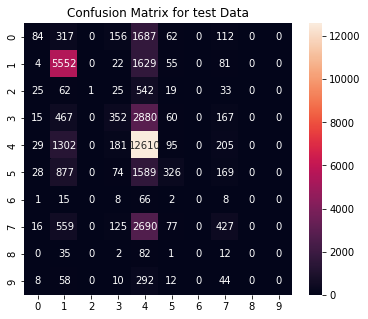

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for test Data')
plt.show()

# 3.B. Fine-tune the entire BERT model:

## 3.B.1. ADAM:

In [ ]:
# Unfreeze all parameters
for p in pretrained_bert_model.parameters():
  p.requires_grad = True

model_bert_finetune = BERT()
model_bert_finetune.to(device)
optimizer = torch.optim.Adam(model_bert_finetune.parameters(), lr = 5e-5)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
epoch = 3
best_test_loss = np.Inf
patient = k = 1
tic = time.time()
for epc in range(epoch):
    print(f'\nEpoch: {epc+1}\n----------------------------------------')
    model_bert_finetune.train()
    train_loop(train_dataloader, model_bert_finetune, loss_fn, optimizer)
    model_bert_finetune.eval()
    print("Test Results:")
    test_loss = test_loop(test_dataloader, model_bert_finetune, loss_fn)
    if test_loss < best_test_loss:
      best_test_loss = test_loss
      torch.save(model_bert_finetune, './best_model_bert_finetune_adam.h5')
      patient = k
    else:
      patient -= 1
      if patient == 0:
        print('Eearly stopping!') 
        break
if patient !=0:
  print('Done!')
model_bert_finetune_adam = torch.load('./best_model_bert_finetune_adam.h5')
print(f'best test loss: {best_test_loss:.3f}')
toc = time.time()
print(f'Run time: {(toc-tic)//60} min {(toc-tic)%60} sec')


Epoch: 1
----------------------------------------
loss: 2.406879  [    0/206513]
loss: 1.180213  [19200/206513]
loss: 1.052579  [38400/206513]
loss: 0.982484  [57600/206513]
loss: 0.935909  [76800/206513]
loss: 0.898292  [96000/206513]
loss: 0.867720  [115200/206513]
loss: 0.842062  [134400/206513]
loss: 0.818389  [153600/206513]
loss: 0.799250  [172800/206513]
loss: 0.781999  [192000/206513]
Test Results:
Accuracy: 79.9%, Average loss: 0.592771 


Epoch: 2
----------------------------------------
loss: 0.479506  [    0/206513]
loss: 0.449674  [19200/206513]
loss: 0.452626  [38400/206513]
loss: 0.456156  [57600/206513]
loss: 0.452889  [76800/206513]
loss: 0.453605  [96000/206513]
loss: 0.455796  [115200/206513]
loss: 0.455494  [134400/206513]
loss: 0.455708  [153600/206513]
loss: 0.454361  [172800/206513]
loss: 0.453604  [192000/206513]
Test Results:
Accuracy: 83.3%, Average loss: 0.493402 


Epoch: 3
----------------------------------------
loss: 0.333103  [    0/206513]
loss: 0.2623

In [ ]:
# If you want to save time, load the trained model instead of training it.
# !gdown 1tGaweTZw_zMwKiXb-x3X-VeiwdpBdeMD
# model_bert_finetune_adam = torch.load('./best_model_bert_finetune_adam.h5', map_location=torch.device(device))

In [ ]:
Y = []
Pred = []
with torch.no_grad():
  for X, y in test_dataloader:
    input_id = X['input_ids'].squeeze(1).to(device)
    attention_mask = X['attention_mask'].to(device)
    y = y.cpu().data.numpy()
    pred = model_bert_finetune_adam(input_id, attention_mask).argmax(dim=1).data.cpu().numpy()
    Y.extend(y)
    Pred.extend(pred)

In [ ]:
acc = accuracy_score(Y, Pred)
f1 = f1_score(Y, Pred, average='micro')
cf = confusion_matrix(Y, Pred)
print(f'accuracy on test data: {100*acc:.2f} %')
print(f'f1 score on test data: {100*f1:.2f} %')

accuracy on test data: 83.31 %
f1 score on test data: 83.31 %


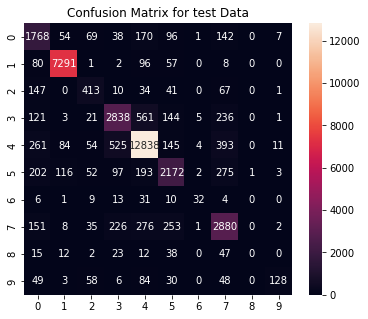

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for test Data')
plt.show()

## 3.B.2. SGD:

In [ ]:
model_bert_finetune = BERT()
model_bert_finetune.to(device)
optimizer = torch.optim.SGD(model_bert_finetune.parameters(), lr = 5e-5)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
epoch = 3
best_test_loss = np.Inf
patient = k = 1
tic = time.time()
for epc in range(epoch):
    print(f'\nEpoch: {epc+1}\n----------------------------------------')
    model_bert_finetune.train()
    train_loop(train_dataloader, model_bert_finetune, loss_fn, optimizer)
    model_bert_finetune.eval()
    print("Test Results:")
    test_loss = test_loop(test_dataloader, model_bert_finetune, loss_fn)
    if test_loss < best_test_loss:
      best_test_loss = test_loss
      torch.save(model_bert_finetune, './best_model_bert_finetune_sgd.h5')
      patient = k
    else:
      patient -= 1
      if patient == 0:
        print('Eearly stopping!') 
        break
if patient !=0:
  print('Done!')
model_bert_finetune_sgd = torch.load('./best_model_bert_finetune_sgd.h5')
print(f'best test loss: {best_test_loss:.3f}')
toc = time.time()
print(f'Run time: {(toc-tic)//60:.0f} min {(toc-tic)%60:.0f} sec')


Epoch: 1
----------------------------------------
loss: 2.636064  [    0/206513]
loss: 2.141337  [19200/206513]
loss: 1.793197  [38400/206513]
loss: 1.558480  [57600/206513]
loss: 1.391188  [76800/206513]
loss: 1.269166  [96000/206513]
loss: 1.170666  [115200/206513]
loss: 1.089922  [134400/206513]
loss: 1.023139  [153600/206513]
loss: 0.966659  [172800/206513]
loss: 0.917938  [192000/206513]
Test Results:
Accuracy: 82.1%, Average loss: 0.630911 


Epoch: 2
----------------------------------------
loss: 0.568497  [    0/206513]
loss: 0.429286  [19200/206513]
loss: 0.417666  [38400/206513]
loss: 0.411059  [57600/206513]
loss: 0.401476  [76800/206513]
loss: 0.395051  [96000/206513]
loss: 0.386918  [115200/206513]
loss: 0.379962  [134400/206513]
loss: 0.373667  [153600/206513]
loss: 0.367098  [172800/206513]
loss: 0.361335  [192000/206513]
Test Results:
Accuracy: 82.8%, Average loss: 0.554542 


Epoch: 3
----------------------------------------
loss: 0.365097  [    0/206513]
loss: 0.2994

In [ ]:
# If you want to save time, load the trained model instead of training it.
# !gdown 1-7iYBikauHZAL35zhT7edlVX_vNDa0C4
# model_bert_finetune_sgd = torch.load('./best_model_bert_finetune_sgd.h5', map_location=torch.device(device))

In [ ]:
Y = []
Pred = []
with torch.no_grad():
  for X, y in test_dataloader:
    input_id = X['input_ids'].squeeze(1).to(device)
    attention_mask = X['attention_mask'].to(device)
    y = y.cpu().data.numpy()
    pred = model_bert_finetune_sgd(input_id, attention_mask).argmax(dim=1).data.cpu().numpy()
    Y.extend(y)
    Pred.extend(pred)

In [ ]:
acc = accuracy_score(Y, Pred)
f1 = f1_score(Y, Pred, average='micro')
cf = confusion_matrix(Y, Pred)
print(f'accuracy on test data: {100*acc:.2f} %')
print(f'f1 score on test data: {100*f1:.2f} %')

accuracy on test data: 83.30 %
f1 score on test data: 83.30 %


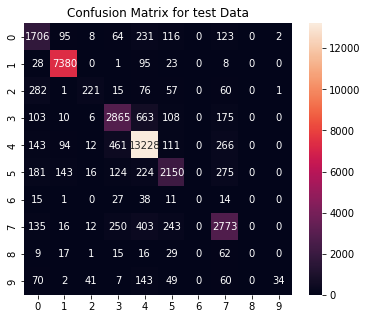

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cf, annot=True, fmt='.0f')
plt.title('Confusion Matrix for test Data')
plt.show()

In this problem, The accuracy of the Adam and SGD optimizer is almost the same, but SGD is faster.

# 3.C. Perplexity:

The perplexity $PP$ of a discrete probability distribution $p$ is defined as:

$\mathit{PP}(p) := e^{H(p)}=e^{-\sum_x p(x)\log p(x)}=\prod_x p(x)^{-p(x)}$

where $H(p)$ is the entropy of the distribution and $x$ ranges over events.

In [ ]:
test_dataloader = torch.utils.data.DataLoader(ds_test, batch_size=1000, shuffle=True)
with torch.no_grad():
  X, y = next(iter(test_dataloader))
  input_id = X['input_ids'].squeeze(1).to(device)
  attention_mask = X['attention_mask'].to(device)
  y = y.to(device)
  pred = model_bert_finetune_adam(input_id, attention_mask)
  H = F.cross_entropy(pred, y)
  PP_model_bert_finetune_adam = torch.exp(H)

  pred = model_bert(input_id, attention_mask)
  H = F.cross_entropy(pred, y)
  PP_model_bert = torch.exp(H)

In [ ]:
print(f'Perplexity before fine-tuning: {PP_model_bert:.2f}')
print(f'Perplexity after fine-tuning: {PP_model_bert_finetune_adam:.2f}')

Perplexity before fine-tuning: 3.82
Perplexity after fine-tuning: 1.57
